# Pre processing

## Libraries

In [2]:
import os
import re
import zipfile
from shutil import copyfile
import unicodedata

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Read data from Google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First we create dataframes of news and summaries identifying the category and the id of the article.

In [ ]:
copyfile('/content/drive/MyDrive/Text Mining Project/archive.zip', 'archive.zip')
zipf = zipfile.ZipFile('archive.zip')
zipf.extractall()
zipf.close()

In [ ]:
# Import dataset
directory_news = "/content/BBC News Summary/News Articles"
directory_summ = "/content/BBC News Summary/Summaries"
categories = ['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
tuples = []
for c in categories:
    for dirname, _, filenames in os.walk(f"{directory_news}/{c}"):
        for filename in filenames:
            article_id = filename.split('.')[0]
            try:
                lines = ' '.join(open(f"{directory_news}/{c}/{filename}").readlines())
                tuples.append((c, article_id, lines))
            except:
                print(f"Failed: {c}/{article_id}")
                pass

Failed: sport/199


In [ ]:
# Define a dataframe which contains the different articles
text_df = pd.DataFrame()
text_df['category'] = [t[0] for t in tuples]
text_df['article_id'] = [t[1] for t in tuples]
text_df['content'] = [t[2] for t in tuples]

In [ ]:
text_df

,category,article_id,content
0,business,071,Japan turns to beer alternatives\n \n Japanese...
1,business,394,US Airways staff agree to pay cut\n \n A union...
2,business,129,Iraq to invite phone licence bids\n \n Iraq is...
3,business,463,US economy still growing says Fed\n \n Most ar...
4,business,177,Optimism remains over UK housing\n \n The UK p...
...,...,...,...
2219,tech,091,Movie body targets children's PCs\n \n The bod...
2220,tech,308,Microsoft makes anti-piracy move\n \n Microsof...
2221,tech,202,Remote control rifle range debuts\n \n Soon yo...
2222,tech,032,Mobile networks seek turbo boost\n \n Third-ge...


In [ ]:
tuples2 = []
for c in categories:
    for dirname, _, filenames in os.walk(f"{directory_summ}/{c}"):
        for filename in filenames:
            article_id = filename.split('.')[0]
            try:
                lines = ' '.join(open(f"{directory_summ}/{c}/{filename}").readlines())
                tuples2.append((c, article_id, lines))
            except:
                print(f"Failed: {c}/{article_id}")
                pass

In [ ]:
# Define a dataframe which contains the different articles summaries
summ_df = pd.DataFrame()
summ_df['category'] = [t[0] for t in tuples2]
summ_df['article_id'] = [t[1] for t in tuples2]
summ_df['content'] = [t[2] for t in tuples2]

In [ ]:
summ_df

,category,article_id,content
0,business,071,Asahi is predicting profits to rise 50% in 200...
1,business,394,The seventh largest carrier in the US sought b...
2,business,129,The ministry said that it wanted to increase I...
3,business,463,Most areas of the US saw their economy continu...
4,business,177,"Wimpey said the UK housing market had proved ""..."
...,...,...,...
2220,tech,091,The Movie Association for America's (MPAA) fre...
2221,tech,308,Microsoft releases regular security updates to...
2222,tech,202,Mr Underwood also lets people come in person t...
2223,tech,032,"The system is not available commercially yet, ..."


Now we merge the two datasets into one dataset with these columns: category, article_id, text and summary

In [ ]:
dfinal = pd.merge(text_df, summ_df, how='inner', left_on=['category', 'article_id'],
                  right_on=['category', 'article_id'])
dfinal.rename(columns={'content_x': 'text', 'content_y': 'summary'}, inplace=True)
dfinal

,category,article_id,text,summary
0,business,071,Japan turns to beer alternatives\n \n Japanese...,Asahi is predicting profits to rise 50% in 200...
1,business,394,US Airways staff agree to pay cut\n \n A union...,The seventh largest carrier in the US sought b...
2,business,129,Iraq to invite phone licence bids\n \n Iraq is...,The ministry said that it wanted to increase I...
3,business,463,US economy still growing says Fed\n \n Most ar...,Most areas of the US saw their economy continu...
4,business,177,Optimism remains over UK housing\n \n The UK p...,"Wimpey said the UK housing market had proved ""..."
...,...,...,...,...
2219,tech,091,Movie body targets children's PCs\n \n The bod...,The Movie Association for America's (MPAA) fre...
2220,tech,308,Microsoft makes anti-piracy move\n \n Microsof...,Microsoft releases regular security updates to...
2221,tech,202,Remote control rifle range debuts\n \n Soon yo...,Mr Underwood also lets people come in person t...
2222,tech,032,Mobile networks seek turbo boost\n \n Third-ge...,"The system is not available commercially yet, ..."


In [ ]:
dfinal.to_csv('/content/drive/MyDrive/Text Mining Project/raw_data.csv', index=False)

In [4]:
# dfinal = pd.read_csv('/content/drive/MyDrive/Text Mining Project/raw_data.csv')

### Class distribution

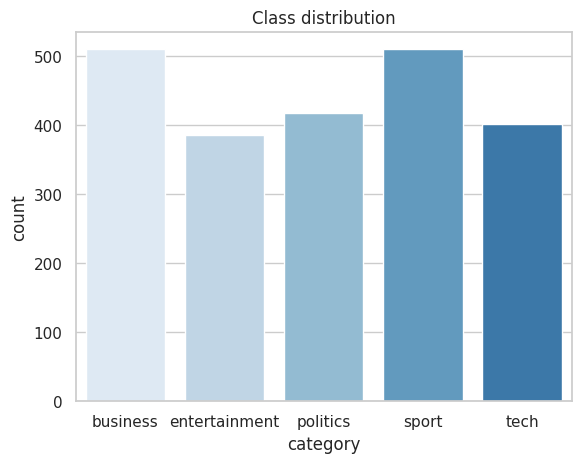

In [ ]:
sns.set(style="whitegrid")
sns.set_palette("Blues")
sns.countplot(data=dfinal, x='category')
plt.title('Class distribution')
plt.show()

## Normalization

Normalization is the process of transforming data into a standard and consistent form. This can include converting the data to lowercase, removing punctuation, numbers, and special characters, expanding contractions, and correcting spelling errors. Normalization can reduce the noise and variability in data and make it easier to compare and analyze.

In [5]:
# Function to expand common english abbreviation, focus on 'not' case.
def decontracted(phrase):
    # specific for not
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general not cases
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    # general
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'s", " ", phrase)
    return phrase

# function to remove punctuation
def remove_punct(phrase):
    # remove punctuation
    phrase = re.sub('[^\w\s]',' ', phrase)
    # remove dot
    phrase = re.sub('\.', ' ', phrase)
    # remove underscore
    phrase = re.sub('_', ' ', phrase)
    # remove numbers with letters attached to them
    phrase = re.sub('\d+[a-zA-Z]+', '', phrase)
    # remove number
    phrase = re.sub('\d+','', phrase)
    # remove extra spaces
    phrase = re.sub('\s{2,}', ' ', phrase)
    return phrase

# function to replace accents with normal letter (e.g ù -> u, ò -> o)
def accents_replace(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

In [6]:
# defining a function for concatenate all the normalization steps
# in this way we can easily apply this function to all rows of a dataframe
def normalization(unnormalized_text):
  # 1. converting text to lowercase
  lowercase_text = unnormalized_text.lower()
  # 2. removing punctuation
  nopunct_text = remove_punct(lowercase_text)
  # 3. replacement abbreviation (we want to preserve all the words, e.g. don't -> do not)
  decontracted_text = decontracted(nopunct_text)
  # 4. replacement accents with normal letters
  normalized_text =  accents_replace(decontracted_text)
  return normalized_text

In [7]:
# apply normalization step
dfinal['norm_text'] = dfinal['text'].apply(normalization)

In [8]:
i = 5

In [9]:
print("<-------- Before normalization -------->")
print(dfinal.loc[i]['text'], '\n\n')

print("<-------- After normalization -------->")
print(dfinal.loc[i]['norm_text'])

<-------- Before normalization -------->
Deutsche Telekom sees mobile gain
 
 German telecoms firm Deutsche Telekom saw strong fourth quarter profits on the back of upbeat US mobile earnings and better-than-expected asset sales.
 
 Net profit came in at 1.4bn euros (£960m; $1.85bn), a dramatic change from the loss of 364m euros in 2003. Sales rose 2.8% to 14.96bn euros. Sales of stakes in firms including Russia's OAO Mobile Telesystems raised 1.17bn euros. This was more than expected and helped to bring debt down to 35.8bn euros.
 
 A year ago, debt was more than 11bn euros higher. T-Mobile USA, the company's American mobile business, made a strong contribution to profits. "It's a seminal achievement that they cut debt so low. That gives them some head room to invest in growth now," said Hannes Wittig, telecoms analyst at Dresdner Kleinwort Wasserstein. The company also said it would resume paying a dividend, after two years in which it focused on cutting debt.
 


<-------- After norm

## Stop-words removal

Stop words are words that are very common and have little or no semantic value, such as articles, prepositions, and conjunctions. Removing stop words can reduce the size and complexity of data and focus on the words that are relevant and informative for our task. However, we should be careful not to remove words that may have contextual or domain-specific importance.

In [10]:
# Create a set of stop words
stop_words = list(set(stopwords.words('english'))) + ['bbc', 'said', 'say', 'new']

# Define a function to remove stop words from a sentence
def remove_stop_words(sentence):
  # Split the sentence into individual words
  words = sentence.split()

  # Use a list comprehension to remove stop words
  filtered_words = [word for word in words if word not in stop_words]

  # Join the filtered words back into a sentence
  return ' '.join(filtered_words)

In [12]:
# apply normalization step
dfinal['clean_text'] = dfinal['norm_text'].apply(remove_stop_words)

In [13]:
print("<-------- Before stop-words removal -------->")
print(dfinal.loc[i]['norm_text'], '\n\n')

print("<-------- After stop-words removal -------->")
print(dfinal.loc[i]['clean_text'])


<-------- Before stop-words removal -------->
deutsche telekom sees mobile gain german telecoms firm deutsche telekom saw strong fourth quarter profits on the back of upbeat us mobile earnings and better than expected asset sales net profit came in at euros a dramatic change from the loss of euros in sales rose to euros sales of stakes in firms including russia s oao mobile telesystems raised euros this was more than expected and helped to bring debt down to euros a year ago debt was more than euros higher t mobile usa the company s american mobile business made a strong contribution to profits it s a seminal achievement that they cut debt so low that gives them some head room to invest in growth now said hannes wittig telecoms analyst at dresdner kleinwort wasserstein the company also said it would resume paying a dividend after two years in which it focused on cutting debt  


<-------- After stop-words removal -------->
deutsche telekom sees mobile gain german telecoms firm deutsche

## Tokenization

Tokenization is the process of splitting data into smaller units, such as words, sentences, or n-grams. Tokenization can help you to extract meaningful information and features from data and prepare it for further analysis. We choose the appropriate level and method of tokenization based on our data and task.

In [14]:
# applying ntlk word_tokenize method
dfinal['token_text'] = dfinal['clean_text'].apply(word_tokenize)

In [15]:
# inspect first 3 rows for checking results
dfinal[['text', 'token_text']].head(3)

,text,token_text
0,German growth goes into reverse\n \n Germany's...,"[german, growth, goes, reverse, germany, econo..."
1,Share boost for feud-hit Reliance\n \n The boa...,"[share, boost, feud, hit, reliance, board, ind..."
2,German bidder in talks with LSE\n \n Deutsche ...,"[german, bidder, talks, lse, deutsche, boerse,..."


## Stemming/Lemmatization

Stemming and lemmatization are techniques that reduce words to their base or root form. Stemming usually involves chopping off the suffixes of words, while lemmatization uses a dictionary or a morphological analyzer to find the canonical form of words. Both techniques can help to group words that have similar meanings and reduce the dimensionality and sparsity of data. However, we should be aware of the trade-offs between accuracy and simplicity. For example, stemming may be faster and easier, but it may also produce inaccurate or non-existent words, while lemmatization may be more accurate and meaningful, but it may also require more resources and time.

In [16]:
# define porter stemmer with default NLTK_EXTENSIONS. It is an improvement of standard porter
porter = PorterStemmer()

# function to apply stemmatization on a token list. It works with nltk stemmer that
# provide the stem() method
def stemSentence(token_words, stemmer):
  # empty list for support
  stem_text=[]
  # stemming each token in the list
  for word in token_words:
    stem_text.append(stemmer.stem(word))
  return stem_text

In [17]:
# Stemming all the row in the dataset
dfinal['stem_text'] = dfinal['token_text'].apply(lambda x: stemSentence(x, porter))

In [18]:
dfinal[['token_text', 'stem_text']].head()

,token_text,stem_text
0,"[german, growth, goes, reverse, germany, econo...","[german, growth, goe, revers, germani, economi..."
1,"[share, boost, feud, hit, reliance, board, ind...","[share, boost, feud, hit, relianc, board, indi..."
2,"[german, bidder, talks, lse, deutsche, boerse,...","[german, bidder, talk, lse, deutsch, boers, bo..."
3,"[news, corp, eyes, video, games, market, news,...","[news, corp, eye, video, game, market, news, c..."
4,"[q, malcolm, glazer, man, utd, battle, control...","[q, malcolm, glazer, man, utd, battl, control,..."


In [19]:
dfinal.head()

,category,article_id,text,summary,norm_text,clean_text,token_text,stem_text
0,business,73,German growth goes into reverse\n \n Germany's...,The figures confounded hopes of a 0.2% expansi...,german growth goes into reverse germany s econ...,german growth goes reverse germany economy shr...,"[german, growth, goes, reverse, germany, econo...","[german, growth, goe, revers, germani, economi..."
1,business,352,Share boost for feud-hit Reliance\n \n The boa...,The board of Indian conglomerate Reliance has ...,share boost for feud hit reliance the board of...,share boost feud hit reliance board indian con...,"[share, boost, feud, hit, reliance, board, ind...","[share, boost, feud, hit, relianc, board, indi..."
2,business,279,German bidder in talks with LSE\n \n Deutsche ...,"Deutsche Boerse bosses have held ""constructive...",german bidder in talks with lse deutsche boers...,german bidder talks lse deutsche boerse bosses...,"[german, bidder, talks, lse, deutsche, boerse,...","[german, bidder, talk, lse, deutsch, boers, bo..."
3,business,447,News Corp eyes video games market\n \n News Co...,"According to the Financial Times, chief operat...",news corp eyes video games market news corp th...,news corp eyes video games market news corp me...,"[news, corp, eyes, video, games, market, news,...","[news, corp, eye, video, game, market, news, c..."
4,business,242,Q&A: Malcolm Glazer and Man Utd\n \n The battl...,"In October 2004, Manchester United said they h...",q a malcolm glazer and man utd the battle for ...,q malcolm glazer man utd battle control manche...,"[q, malcolm, glazer, man, utd, battle, control...","[q, malcolm, glazer, man, utd, battl, control,..."


In [20]:
df_classif = dfinal[['category', 'article_id', 'stem_text']]
df_classif = df_classif.rename(columns={'stem_text': 'text'})

In [22]:
df_classif.to_csv('/content/drive/MyDrive/Text Mining Project/clean_text.csv', index=False)

### Word Cloud
Words occurring frequently in the corpus form a Word Cloud. Words with higher frequency have larger font. Visualization to understand the topic in discussion in the given text


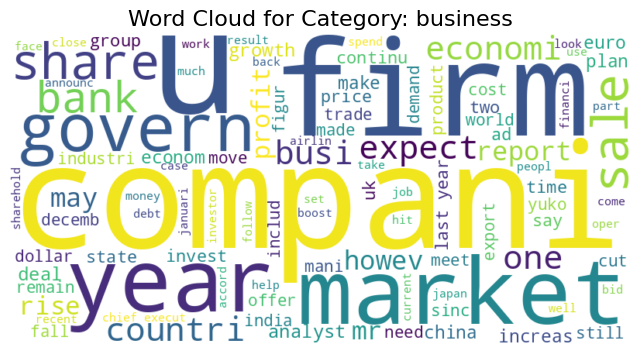

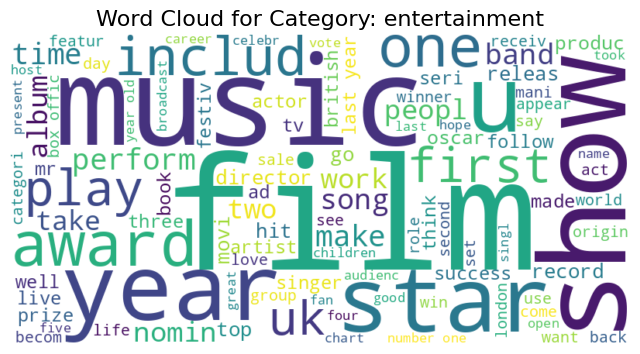

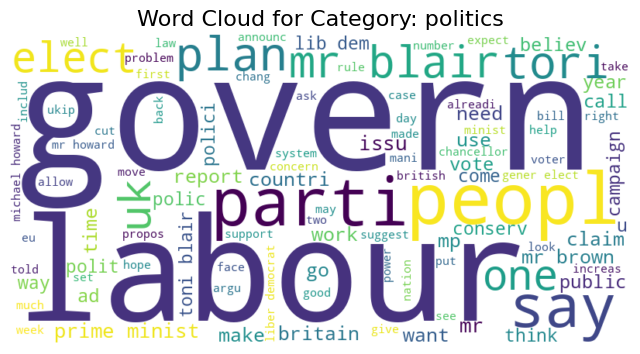

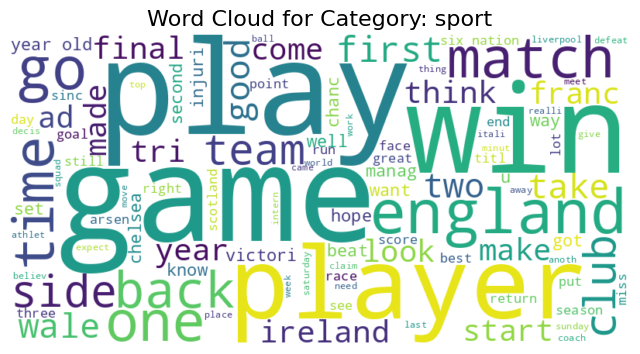

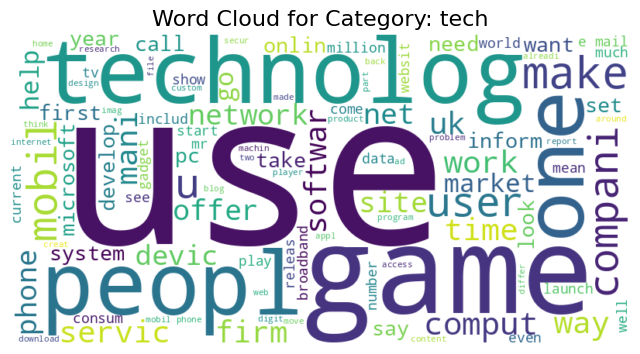

In [21]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100)

# Generate word clouds for each category
categories = df_classif['category'].unique()
for category in categories:
    # Filter data for the specific category
    category_data = df_classif[df_classif['category'] == category]['text'].values

    # Concatenate all texts in the category
    text_for_category = ' '.join([' '.join(tokens) for tokens in category_data])

    # Generate word cloud
    wordcloud.generate(text_for_category)

    # Display the word cloud
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}', fontsize=16)
    plt.axis('off')
    plt.show()